In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# Set seed for reproducibility
torch.manual_seed(66)


In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")


Device being used: cuda


In [3]:
def prepare_data(batch_size=128, image_size=64):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print("Data Preparation Complete")
    print(f"Number of training batches: {len(dataloader)}")
    return dataloader

# Prepare data
dataloader = prepare_data()


Files already downloaded and verified
Data Preparation Complete
Number of training batches: 391


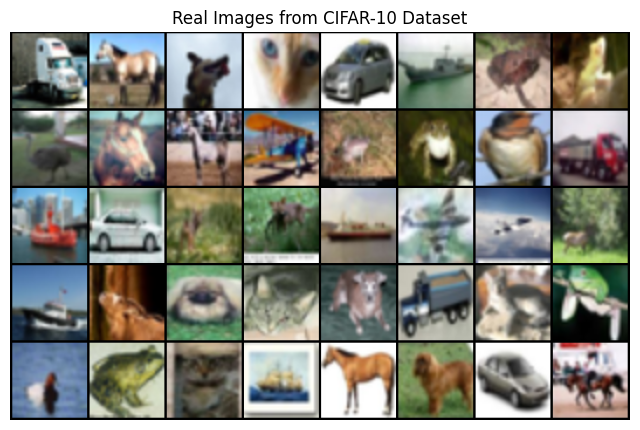

In [7]:
def display_real_images(dataloader, num_images=40):
    
    # Fetch one batch of real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Plot real images in a grid
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Real Images from CIFAR-10 Dataset")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))
    plt.show()

# Example Usage
display_real_images(dataloader)


In [8]:
class ACGANGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, num_classes):
        super(ACGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)  # Match embedding size to noise size (nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz + nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeddings = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat([noise, label_embeddings], dim=1)
        return self.main(input)


In [9]:
class ACGANDiscriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(ACGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.adv_head = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        self.aux_head = nn.Conv2d(ndf * 8, num_classes, 4, 1, 0, bias=False)

    def forward(self, input):
        features = self.main(input)
        real_fake = self.adv_head(features).view(-1)
        class_labels = self.aux_head(features).view(-1, 10)
        return real_fake, class_labels


In [10]:
# Hyperparameters
nz = 100  # Size of noise vector
nc = 3    # Number of channels
ngf = 64  # Generator feature size
ndf = 64  # Discriminator feature size
num_classes = 10  # Number of CIFAR-10 classes

# Initialize Generator and Discriminator
netG = ACGANGenerator(nz, nc, ngf, num_classes).to(device)
netD = ACGANDiscriminator(nc, ndf, num_classes).to(device)

print("Generator Model:")
print(netG)
print("\nDiscriminator Model:")
print(netD)


Generator Model:
ACGANGenerator(
  (label_emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2,

In [15]:
# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()  # For real/fake classification
auxiliary_loss = nn.CrossEntropyLoss()     # For class prediction

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

print("Loss functions and optimizers initialized successfully.")


Loss functions and optimizers initialized successfully.


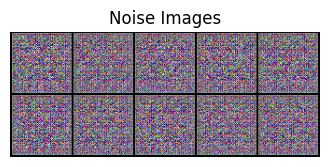

In [18]:
def display_noise_images_acgan(generator, discriminator, nz, num_classes, device, batch_size=1000, num_best=10):
    
    # Generate fake images
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.randint(0, num_classes, (batch_size,), device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()
        fake_images_gpu = generator(noise, labels).detach()

    # Get discriminator scores
    with torch.no_grad():
        scores, _ = discriminator(fake_images_gpu)
        scores = scores.view(-1).detach().cpu().numpy()

    # Select top `num_best` images
    sorted_indices = np.argsort(scores)[::-1][:num_best]
    best_fake_images = torch.stack([fake_images[i] for i in sorted_indices])

    # Plot the best fake images
    grid = torchvision.utils.make_grid(best_fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.title("Noise Images")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Example Usage
display_noise_images_acgan(generator=netG, discriminator=netD, nz=nz, num_classes=num_classes, device=device)


In [19]:
from torchmetrics.image.fid import FrechetInceptionDistance

def train_acgan_with_fid(
    generator, discriminator, dataloader, optimizerG, optimizerD,
    adversarial_loss, auxiliary_loss, nz, num_classes, device, num_epochs
):
    """
    Train the ACGAN with FID score calculation for each epoch.

    Args:
    - generator: Generator network.
    - discriminator: Discriminator network.
    - dataloader: DataLoader for the dataset.
    - optimizerG: Optimizer for the generator.
    - optimizerD: Optimizer for the discriminator.
    - adversarial_loss: Loss function for real/fake classification.
    - auxiliary_loss: Loss function for class prediction.
    - nz: Size of the latent noise vector.
    - num_classes: Number of image classes.
    - device: Device to use for training (CPU or GPU).
    - num_epochs: Number of epochs for training.

    Returns:
    - G_losses: List of generator losses.
    - D_losses: List of discriminator losses.
    - FID_scores: List of FID scores for each epoch.
    """
    G_losses, D_losses, FID_scores = [], [], []

    # Initialize FID metric
    fid_metric = FrechetInceptionDistance(feature=2048).to(device)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(dataloader):
            batch_size = real_images.size(0)

            # Move data to device
            real_images = real_images.to(device)
            labels = labels.to(device)
            valid = torch.ones(batch_size, device=device)  # Real labels
            fake = torch.zeros(batch_size, device=device)  # Fake labels

            # ---------------------
            # Train Discriminator
            # ---------------------
            discriminator.zero_grad()

            # Real images
            real_validity, real_aux = discriminator(real_images)
            d_real_loss = adversarial_loss(real_validity, valid) + auxiliary_loss(real_aux, labels)

            # Fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = generator(noise, fake_labels)
            fake_validity, fake_aux = discriminator(fake_images.detach())
            d_fake_loss = adversarial_loss(fake_validity, fake) + auxiliary_loss(fake_aux, fake_labels)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizerD.step()

            # -----------------
            # Train Generator
            # -----------------
            generator.zero_grad()

            # Generate fake images and calculate loss
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            gen_images = generator(noise, gen_labels)
            validity, pred_labels = discriminator(gen_images)
            g_loss = adversarial_loss(validity, valid) + auxiliary_loss(pred_labels, gen_labels)

            g_loss.backward()
            optimizerG.step()

            # Save losses for visualization
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

        # ----------------------
        # Calculate FID Score
        # ----------------------
        fid_metric.reset()

        # Add real images to FID metric
        for real_batch, _ in dataloader:
            real_batch = (real_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
            real_batch = real_batch.to(torch.uint8).to(device)
            fid_metric.update(real_batch, real=True)

        # Add fake images to FID metric
        with torch.no_grad():
            for _ in range(len(dataloader)):
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
                fake_batch = generator(noise, fake_labels)
                fake_batch = (fake_batch * 0.5 + 0.5) * 255  # Denormalize to [0, 255]
                fake_batch = fake_batch.to(torch.uint8).to(device)
                fid_metric.update(fake_batch, real=False)

        fid_score = fid_metric.compute().item()
        FID_scores.append(fid_score)

        # Log progress
        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"- Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}, FID: {fid_score:.4f}"
        )

    print("\nTraining Complete!")
    return G_losses, D_losses, FID_scores


# Train the model
num_epochs = 100
G_losses, D_losses, FID_scores = train_acgan_with_fid(
    generator=netG,
    discriminator=netD,
    dataloader=dataloader,
    optimizerG=optimizerG,
    optimizerD=optimizerD,
    adversarial_loss=adversarial_loss,
    auxiliary_loss=auxiliary_loss,
    nz=nz,
    num_classes=num_classes,
    device=device,
    num_epochs=num_epochs
)


Starting Training...

Epoch [1/100] - Loss_D: 1.0518, Loss_G: 2.3413, FID: 344.6206
Epoch [2/100] - Loss_D: 0.9073, Loss_G: 2.6155, FID: 350.3037
Epoch [3/100] - Loss_D: 0.7399, Loss_G: 4.2441, FID: 343.6495
Epoch [4/100] - Loss_D: 1.1528, Loss_G: 2.8416, FID: 321.7246
Epoch [5/100] - Loss_D: 0.6618, Loss_G: 3.3819, FID: 336.1239
Epoch [6/100] - Loss_D: 0.8018, Loss_G: 4.2581, FID: 328.7538
Epoch [7/100] - Loss_D: 0.6639, Loss_G: 3.6671, FID: 311.7157
Epoch [8/100] - Loss_D: 0.6458, Loss_G: 4.0097, FID: 281.3400
Epoch [9/100] - Loss_D: 0.6256, Loss_G: 2.1695, FID: 271.3290
Epoch [10/100] - Loss_D: 0.5155, Loss_G: 4.8600, FID: 294.7910
Epoch [11/100] - Loss_D: 0.5151, Loss_G: 2.0295, FID: 289.2235
Epoch [12/100] - Loss_D: 0.4851, Loss_G: 4.5362, FID: 283.0527
Epoch [13/100] - Loss_D: 0.3956, Loss_G: 3.0625, FID: 273.3078
Epoch [14/100] - Loss_D: 0.2642, Loss_G: 5.1701, FID: 282.7495
Epoch [15/100] - Loss_D: 0.3320, Loss_G: 4.0927, FID: 269.2261
Epoch [16/100] - Loss_D: 0.3770, Loss_G: 5

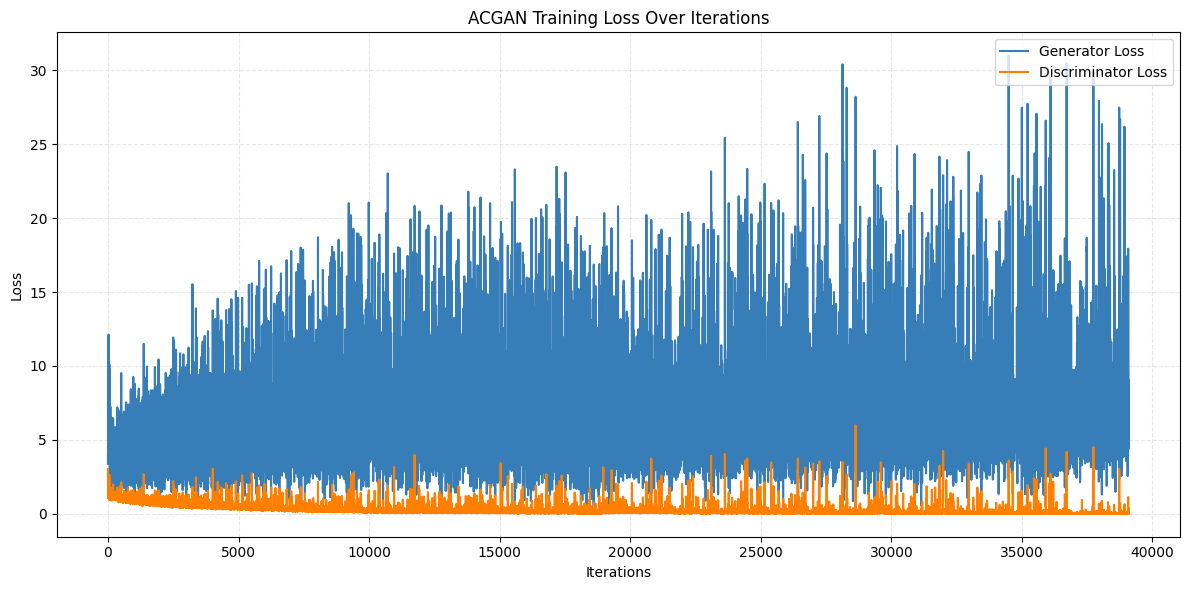

In [20]:
def plot_acgan_iterative_loss_graphs(G_losses, D_losses):
    """
    Plots generator and discriminator loss during training for every iteration.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(G_losses, label="Generator Loss", color="#377eb8")  # Blue
    plt.plot(D_losses, label="Discriminator Loss", color="#ff7f00")  # Orange
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("ACGAN Training Loss Over Iterations")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acgan_iterative_loss_graphs(G_losses, D_losses)


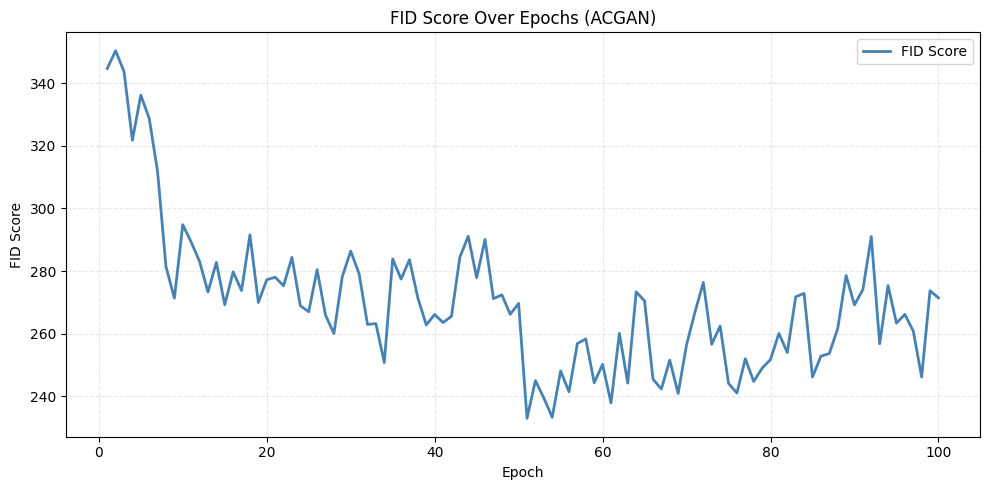

In [21]:
def plot_acgan_fid_scores(FID_scores, num_epochs):
    
    # Plot FID scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), FID_scores, label="FID Score", color="steelblue", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.title("FID Score Over Epochs (ACGAN)")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Example Usage
plot_acgan_fid_scores(FID_scores, num_epochs=100)


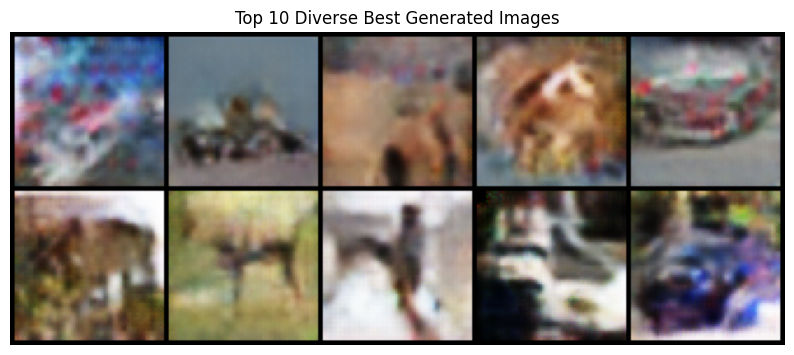

In [37]:
def display_top_10_diverse_fake_images_v2(generator, discriminator, nz, num_classes, device, batch_size=5000, num_best=10):
    """
    Display the top `num_best` diverse fake images based on discriminator scores.
    """
    # Generate a larger batch of fake images for better selection
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.arange(num_classes, device=device).repeat_interleave(batch_size // num_classes)[:batch_size]
    
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()
        fake_images_gpu = generator(noise, labels).detach()

    # Get discriminator scores for the generated fake images
    with torch.no_grad():
        scores, _ = discriminator(fake_images_gpu)
        scores = scores.view(-1).detach().cpu().numpy()

    # Sort and filter for top `num_best` images with diverse labels
    sorted_indices = np.argsort(scores)[::-1]
    top_images = []
    seen_labels = set()
    for idx in sorted_indices:
        if len(top_images) >= num_best:
            break
        label = labels[idx].item()
        if label not in seen_labels:
            top_images.append(fake_images[idx])
            seen_labels.add(label)

    # Display the top diverse fake images
    best_fake_images = torch.stack(top_images)
    grid = torchvision.utils.make_grid(best_fake_images, nrow=5, normalize=True, padding=2)

    plt.figure(figsize=(10, 5))
    plt.axis("off")
    plt.title(f"Top {num_best} Diverse Best Generated Images")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Example Usage
display_top_10_diverse_fake_images_v2(
    generator=netG,
    discriminator=netD,
    nz=nz,
    num_classes=num_classes,
    device=device
)


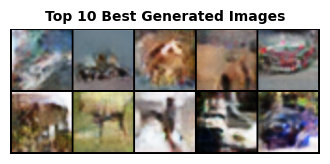

In [39]:
def display_top_10_diverse_fake_images_v2(generator, discriminator, nz, num_classes, device, batch_size=5000, num_best=10):
    """
    Display the top `num_best` diverse fake images based on discriminator scores.
    """
    # Generate a larger batch of fake images for better selection
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    labels = torch.arange(num_classes, device=device).repeat_interleave(batch_size // num_classes)[:batch_size]
    
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()
        fake_images_gpu = generator(noise, labels).detach()

    # Get discriminator scores for the generated fake images
    with torch.no_grad():
        scores, _ = discriminator(fake_images_gpu)
        scores = scores.view(-1).detach().cpu().numpy()

    # Sort and filter for top `num_best` images with diverse labels
    sorted_indices = np.argsort(scores)[::-1]
    top_images = []
    seen_labels = set()
    for idx in sorted_indices:
        if len(top_images) >= num_best:
            break
        label = labels[idx].item()
        if label not in seen_labels:
            top_images.append(fake_images[idx])
            seen_labels.add(label)

    # Display the top diverse fake images
    best_fake_images = torch.stack(top_images)
    grid = torchvision.utils.make_grid(best_fake_images, nrow=5, normalize=True, padding=2)

    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.title(f"Top {num_best} Best Generated Images", fontsize=10, fontweight="bold")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Example Usage
display_top_10_diverse_fake_images_v2(
    generator=netG,
    discriminator=netD,
    nz=nz,
    num_classes=num_classes,
    device=device
)


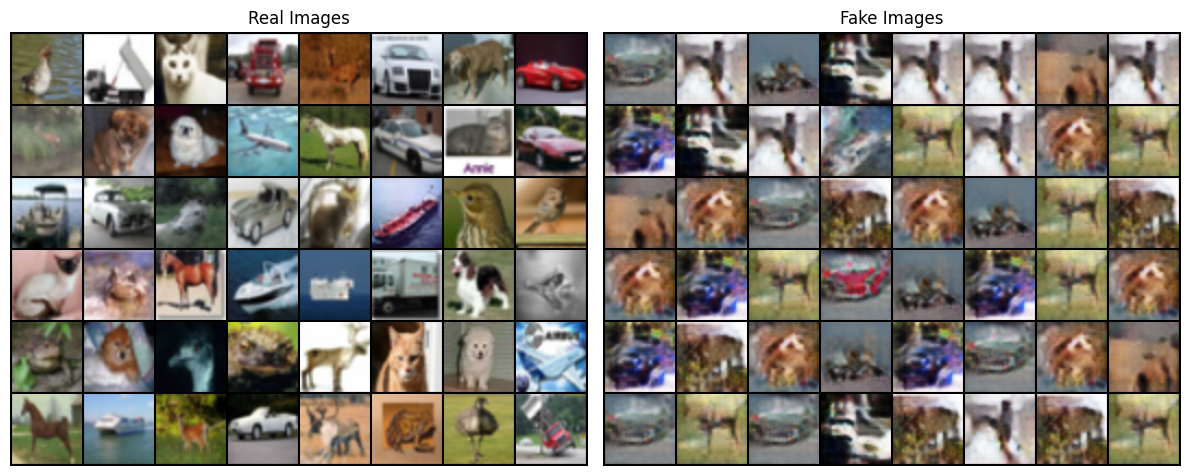

In [40]:
def display_real_and_fake_images_acgan(dataloader, generator, nz, num_classes, device, num_images=48):
    """
    Displays real images on the left and fake images on the right.
    """
    # Fetch real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images] * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Generate fake images
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    labels = torch.randint(0, num_classes, (num_images,), device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu() * 0.5 + 0.5  # Undo normalization to [0, 1]

    # Plot real and fake images side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Real images
    axs[0].axis("off")
    axs[0].set_title("Real Images")
    axs[0].imshow(np.transpose(torchvision.utils.make_grid(real_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    # Fake images
    axs[1].axis("off")
    axs[1].set_title("Fake Images")
    axs[1].imshow(np.transpose(torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=False), (1, 2, 0)))

    plt.tight_layout()
    plt.show()

# Example Usage
display_real_and_fake_images_acgan(
    dataloader=dataloader,
    generator=netG,
    nz=nz,
    num_classes=num_classes,
    device=device,
    num_images=48
)
